In [1]:
import numpy as np
import os
import pandas as pd
import PIL
import PIL.Image
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm())
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import cv2

from keras.models import Sequential, Model
from keras.layers import Input, merge, Activation
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.callbacks import CSVLogger, ModelCheckpoint

0it [00:00, ?it/s]
Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [27]:
def shorten(df):
    collist = [col for col in df.columns if col not in ['img']]
    return df[collist]

def explode_df(data_df):
    exploded_df = []
    
    for col in ['center','left','right']:
        partial_df = data_df[[col] + ['steering','throttle','speed']]
        
        partial_df=partial_df.rename(columns = {col:'img_path'})
        
        exploded_df.append(partial_df)
        
    exploded_df = pd.concat(exploded_df)
    return exploded_df

def change_col_path(data_df, col_name):
    data_df.loc[:,col_name] = data_df.loc[:,col_name].apply(lambda name: data_path + "IMG/" + os.path.basename(name))
    return data_df

def read_imgs(data_df):
    data_df.loc[:,'img'] = data_df.loc[:,'img_path'].progress_apply(lambda path: read_image(path))
    return data_df

def read_df(csv_path, nr_elems = None):
    data_df = pd.read_csv(csv_path,  names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])
    
    if(nr_elems != None):
        data_df = data_df.iloc[:nr_elems]
        
    data_df = explode_df(data_df)    
    data_df = change_col_path(data_df, 'img_path')
    
    data_df = read_imgs(data_df)
    
    data_df = data_df.set_index('img_path')
    
    data_df = shuffle(data_df, random_state = 0)
    return data_df

def plot_imgs(data_df,nr_imgs):
    
    for _,row in  data_df.iloc[:nr_imgs].iterrows():
    
        plt.imshow(row['img'])
        plt.figure()
    
        plt.show()

        
def crop(image):
    return image[60:-25, :, :]

def read_image(path):
    img = PIL.Image.open(path)
    img = np.asarray(img)
    img = crop(img)
    
    return img

def split_train_test(data_df, train_percentage):
    
    nr_train = int(train_percentage * len(data_df))
    train_df = data_df[:nr_train]
    test_df = data_df[nr_train:]
    
    return train_df, test_df


def get_formated_data(data_df):
    imgs = np.stack(data_df['img'].tolist())
    labels = np.stack(data_df['steering'].tolist())
    
#     imgs = np.transpose(imgs,(0,3,1,2))
    return imgs, labels

def get_flipped_df(data_df):
    
    augmented_df = data_df.copy()
    
    augmented_df.loc[:,'img'] = augmented_df.loc[:,'img'].apply(lambda img: cv2.flip(img, 1))
    augmented_df.loc[:,'steering'] = augmented_df.loc[:,'steering'].apply(lambda steering: -steering)
    
    return augmented_df


In [5]:
data_path = "../../datasets/self-driving-car/"
img_path = data_path + "IMG/"
csv_path = data_path + "driving_log.csv"

img_size = (75, 320)

In [7]:
data_df = read_df(csv_path, nr_elems=100)
data_df.shape


100%|██████████| 300/300 [00:02<00:00, 138.42it/s]

(300, 4)

In [8]:
shorten(data_df).head()

,steering,throttle,speed
img_path,,,
../../datasets/self-driving-car/IMG/right_2017_09_30_21_47_22_737.jpg,-0.20,1,14.91182
../../datasets/self-driving-car/IMG/left_2017_09_30_21_47_29_573.jpg,0.00,1,30.19099
../../datasets/self-driving-car/IMG/center_2017_09_30_21_47_23_062.jpg,0.00,1,18.20431
../../datasets/self-driving-car/IMG/right_2017_09_30_21_47_23_723.jpg,-0.45,1,24.19329
../../datasets/self-driving-car/IMG/right_2017_09_30_21_47_25_326.jpg,0.00,1,30.19011


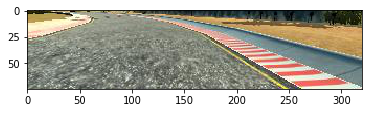

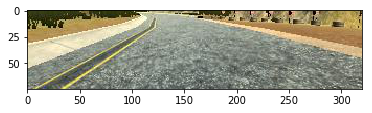

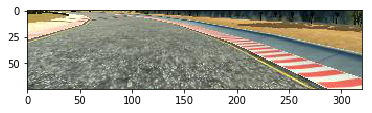

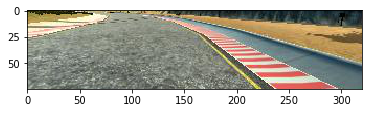

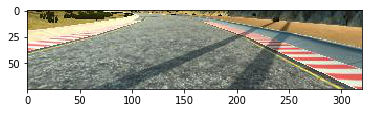

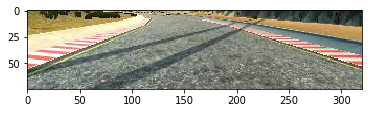

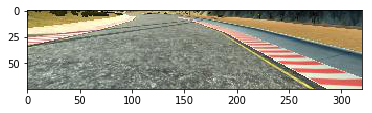

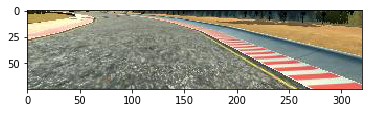

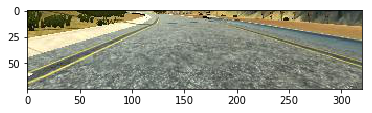

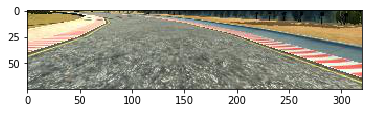

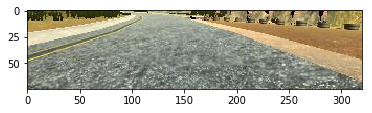

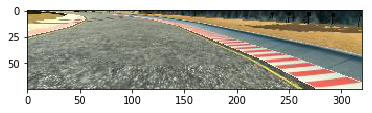

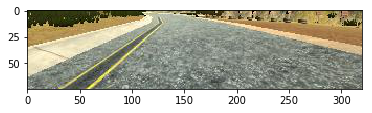

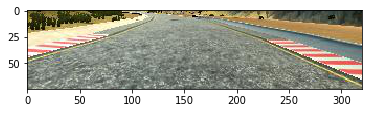

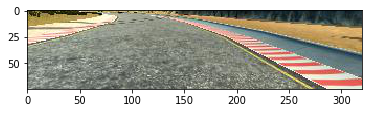

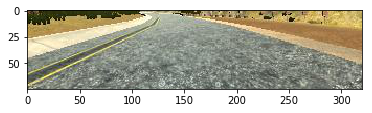

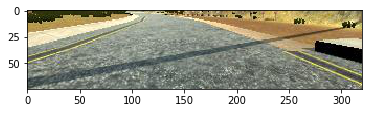

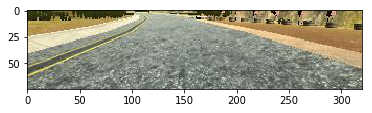

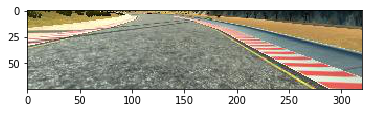

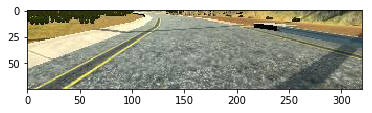

1772it [01:10, 112.68it/s]

In [9]:
plot_imgs(data_df,nr_imgs = 20)

In [10]:
augmented_df = get_flipped_df(data_df)
data_df = pd.concat([data_df,augmented_df])
data_df = shuffle(data_df,random_state = 0)
data_df.shape

(600, 4)

In [28]:
train_df, test_df = split_train_test(data_df, train_percentage = 0.8)

In [29]:
print(train_df.shape)
print(test_df.shape)

(480, 4)
(120, 4)


In [30]:
train_imgs, train_labels = get_formated_data(train_df)
test_imgs, test_labels = get_formated_data(test_df)

In [31]:
print(train_imgs.shape)
print(train_labels.shape)

print(test_imgs.shape)
print(test_labels.shape)

(480, 75, 320, 3)
(480,)
(120, 75, 320, 3)
(120,)


# Model

In [24]:
def get_model():
    
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=img_size + (3,), output_shape = img_size + (3,)))
    model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Flatten())
    
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001))
    
    return model

In [25]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 158, 24)       1824      
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 158, 24)       96        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 77, 36)        21636     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 77, 36)        144       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 37, 48)         43248     
_________________________________________________________________
batch_normalization_3 (Batch (None, 6, 37, 48)         192       
__________

In [33]:
model.fit(train_imgs, train_labels,
      epochs= 20,               
      validation_data = (test_imgs, test_labels),
      callbacks = [CSVLogger("./training.txt"), \
                  ModelCheckpoint("./model_temp.h5", monitor='val_loss', verbose= 1, save_best_only=True, mode='min')
                 ]
      )

Train on 480 samples, validate on 120 samples
Epoch 1/20
480/480 [==============================] - 1s 1ms/step - loss: 3.6395 - val_loss: 0.2454
Epoch 2/20
480/480 [==============================] - 0s 897us/step - loss: 3.3244 - val_loss: 0.2542
Epoch 3/20
480/480 [==============================] - 0s 870us/step - loss: 3.4765 - val_loss: 0.3250
Epoch 4/20
480/480 [==============================] - 0s 931us/step - loss: 3.2201 - val_loss: 0.3672
Epoch 5/20
480/480 [==============================] - 0s 939us/step - loss: 3.3236 - val_loss: 0.4299
Epoch 6/20
480/480 [==============================] - 0s 878us/step - loss: 3.1517 - val_loss: 0.4936
Epoch 7/20
480/480 [==============================] - 0s 917us/step - loss: 2.6966 - val_loss: 0.4567
Epoch 8/20
480/480 [==============================] - 0s 946us/step - loss: 2.6304 - val_loss: 0.4064
Epoch 9/20
480/480 [==============================] - 0s 958us/step - loss: 2.7386 - val_loss: 0.4324
Epoch 10/20
480/480 [=================

In [ ]:
model.save_weights("./first.h5")